# Predicting stock seasonality using TimeSeries Forecasting 

#### This notebook covers the usage of various time series forecasting methods for predicting the stock seasonality and hence the best time of the year to invest in that stock

Based on the analysis of stock data and results of cross-validation following methods have been shortlisted:<br>
<ul>
<li>Seasonal decompose based seasonality forecasting: statsmodels, pmdarima
    <ol>
        <li>statsmodels - Seasonality:additive/multiplicative</li>
        <li>pmdarima - Seasonality:additive/multiplicative</li>
    </ol>
</li>
<li>Timeseries algorithms for seasonality forecasting: 
    <ol>
        <li>Holt-Winters - Trend:None/additive/multiplicative, Seasonality:additive/multiplicative </li>
        <li>Auto-ARIMA - Fourier featurizer to handle seasonality, with and without other exogenous features</li>
    </ol>
</li>
<li>Facebook Prophet for timeseries forecasting: 
    <ol>
        <li>Prediction based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
        <li>Seasonality based: Seasonality: yearly, Mode: additive/multiplicative, Growth:Linear/Logistic</li>
    </ol>
</li>
</ul>

In [1]:
import time
start = time.time()

In [2]:
#Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 

#Statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

#PMD Arima
import pmdarima as pm
#print(f"Using pmdarima {pm.__version__}")

#FB Prophet
from fbprophet import Prophet

#Prediction Accuracy Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from numpy import *

%matplotlib inline
#pd.options.display.float_format = "{:,.4f}".format
pd.options.display.precision = 6
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [3]:
#Initialize the common variables
source_dir =  r'..\data\rawdata' + '\\'
transformed_dir =  r'..\data\inputdata' + '\\'
sma_rolling_window = 5 #Rolling window for simple moving average of stock price
eda_window = 5 #7 #Rolling window for stationarity analysis
min_train_data_years = 5
min_cross_val = 3
max_cross_val = 5
min_years_data_reqd = min_train_data_years + min_cross_val
current_year = datetime.datetime.now().year
stock_tickers = ['TITAN'] #['VOLTAS', 'TWL', 'ESCORTS', 'MARUTI']
cnt_stocks = len(stock_tickers)
print('No. of stocks analysed:', cnt_stocks)
stock_ticker = stock_tickers[0]
print('Selected stock: ' + stock_ticker)

No. of stocks analysed: 1
Selected stock: TITAN


### Load the stock data

In [4]:
group_by_col = 'year'
agg_value_col = 'adj_close'
agg_value_col_sma = 'sma'
wd_col = 'work_doy'
pctile_col = 'pctile'

In [5]:
def load_data(file_path):
    #Select required columns from csv
    #rawdata = pd.read_csv(file_path, index_col=0, usecols=['Date', 'Adj Close'], parse_dates=True)
    rawdata = None
    rawdata = pd.read_csv(file_path, index_col=0, parse_dates=True)
    rawdata = rawdata.dropna(how = 'any') ##Drop rows with empty cells
    rawdata.index.names = ['date']
    rawdata.rename(columns={"Adj Close": "adj_close"}, inplace = True)
    rawdata.sort_index(ascending = True, inplace = True)
    #Sort data by date
    return rawdata.copy()

In [6]:
data = load_data(source_dir + stock_ticker + '.csv')
#years_of_data = len(data.index.year.unique()) - 1 ##-1 for removing current year
data.head()

,High,Low,Open,Close,Volume,adj_close
date,,,,,,
1996-01-01,5.80,5.75,5.8000,5.7500,4000.0,-0.042628
1996-01-02,5.85,5.70,5.8000,5.7525,24000.0,-0.042647
1996-01-03,5.75,5.65,5.7525,5.7000,22000.0,-0.042257
1996-01-04,5.65,5.55,5.6500,5.6075,46000.0,-0.041572
1996-01-05,5.55,5.45,5.5000,5.4550,20000.0,-0.040441


### Transform data 
Add additional columns, remove current year data

<b>Note:</b> We are using a 5 day simple moving average(SMA) as an indicator of time frame for investment rather than a single day's close value. 
<br>Reasons:
<br>There could be multiple days with the same min. value spread across different time frames. Hence, it makes sense to use a simple moving average rather than individual close value.
<br>Also, this will avoid impact of any sudden surges/spikes in the analysis.

In [7]:
def transform_data(rawdf):
    #Simple moving average of adjusted close price with 2 prior and 2 next values
    rawdf['sma'] = rawdf.adj_close.rolling(window=sma_rolling_window, min_periods=1).mean().shift(-2)
    rawdf['year'] = rawdf.index.year
    #Drop current year's records from analysis
    rawdf = rawdf[rawdf.year < current_year] 
    rawdf["month"] = rawdf.index.month
    rawdf['week'] = pd.Int64Index(rawdf.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
    rawdf["day_of_week"] = rawdf.index.dayofweek
    rawdf["day_of_month"] = rawdf.index.day
    #Store day of year
    rawdf['day_of_year'] = rawdf.index.dayofyear
    #Add row count by year to get working day of year, this is column used for align prediction output
    rawdf[wd_col] = rawdf.groupby(['year']).cumcount() + 1
    #Add percentile using rank, this is column used for determining the accuracy of prediction
    rawdf[pctile_col] = 100 * rawdf.groupby("year")["sma"].rank("min", pct=True, ascending=True)    
    #Handle ISO week format for last days of year marked as Week 1
    rawdf.loc[(rawdf['week'] == 1) & (rawdf['day_of_year'] > 350),'week'] = 53 
    return rawdf.copy()

In [8]:
data = transform_data(data.copy())
data.tail(5)

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2019-12-24,1222.000000,1200.650024,1206.050049,1204.099976,2236779.0,1195.029785,1190.772095,2019,12,52,1,24,358,238,73.140496
2019-12-26,1213.750000,1190.599976,1209.949951,1192.500000,1800229.0,1183.517090,1189.154346,2019,12,52,3,26,360,239,72.727273
2019-12-27,1199.199951,1184.849976,1196.449951,1191.449951,1332568.0,1182.474976,1184.956177,2019,12,52,4,27,361,240,72.314050
2019-12-30,1198.000000,1183.099976,1195.000000,1193.750000,1109808.0,1184.757690,1175.160522,2019,12,53,0,30,364,241,70.247934
2019-12-31,1203.699951,1184.199951,1195.000000,1187.949951,1753530.0,1179.001343,1167.836133,2019,12,53,1,31,365,242,66.528926


In [9]:
data.describe()

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
count,5925.000000,5925.000000,5925.000000,5925.000000,5.925000e+03,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000,5925.000000
mean,197.923748,192.007187,195.065302,194.971599,3.794836e+06,184.491468,184.487965,2007.470380,6.502110,26.688945,1.991224,15.766414,182.529451,123.957806,50.200748
std,295.720876,288.193193,292.203437,292.040041,9.617698e+06,289.657419,289.582572,6.915767,3.433983,14.998153,1.411917,8.769275,104.971938,71.307026,28.869304
min,1.440000,1.350000,1.350000,1.375000,0.000000e+00,-0.199329,-0.196883,1996.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.396825
25%,4.400000,4.150000,4.275000,4.295000,5.600000e+05,0.273083,0.269466,2001.000000,4.000000,14.000000,1.000000,8.000000,92.000000,62.000000,25.203252
50%,51.650002,48.474998,50.000000,50.077499,1.424720e+06,30.430750,30.315676,2007.000000,7.000000,27.000000,2.000000,16.000000,183.000000,124.000000,50.200803
75%,277.000000,267.049988,272.100006,272.700012,3.246880e+06,259.142822,257.385553,2013.000000,9.000000,39.000000,3.000000,23.000000,272.000000,186.000000,75.203252
max,1389.949951,1350.650024,1378.900024,1374.550049,1.928336e+08,1364.195801,1333.925537,2019.000000,12.000000,53.000000,4.000000,31.000000,366.000000,252.000000,100.000000


In [10]:
wd_series = data[wd_col]
pctile_series = data[pctile_col]

### Aggregate Data
Derive important yearly metrics

In [11]:
#def agg_data(records):
def agg_data():
    #Aggregate data on yearly basis - Min. day of year will be our output
    year_agg_data = None
    year_agg_data = pd.concat([data.groupby(group_by_col)[agg_value_col].count().rename('record_cnt')
                          , data.groupby(group_by_col)[agg_value_col].mean().rename('mean_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col].min().rename('min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].min().rename('min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().rename('date_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().rename('date_min_' + agg_value_col_sma)
                          , data.groupby(group_by_col)[agg_value_col].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col)
                          , data.groupby(group_by_col)[agg_value_col_sma].idxmin().dt.dayofyear.rename('doy_min_' + agg_value_col_sma)
                          #, data.groupby(group_by_col)[agg_value_col].max().rename('max_' + agg_value_col)
                          #, data.groupby(group_by_col)[agg_value_col].median().rename('median_' + agg_value_col)
                          ], axis=1)
    ## Remove rows for years when the adj_close has -ve values
    year_agg_data = year_agg_data[year_agg_data.min_adj_close > 0]
    
    ##Get working day of min. price
    #wd_min_price = data.loc[data.groupby(group_by_col)[agg_value_col].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_price.rename(columns={wd_col: 'wd_min_'+agg_value_col}, inplace = True)
    #wd_min_sma = data.loc[data.groupby(group_by_col)[agg_value_col_sma].idxmin()][[group_by_col, wd_col]].set_index([group_by_col])
    #wd_min_sma.rename(columns={wd_col: 'wd_min_'+agg_value_col_sma}, inplace = True)
    #year_agg_data = year_agg_data.join(wd_min_price).join(wd_min_sma) 
    year_agg_data['wd_min_'+agg_value_col] = year_agg_data.apply(lambda row: wd_series[row.date_min_adj_close], axis=1)
    year_agg_data['wd_min_'+agg_value_col_sma] = year_agg_data.apply(lambda row: wd_series[row.date_min_sma], axis=1)
    
    ## Check diff. between min. price working day based on actual value and moving avg.
    year_agg_data['target_doy_diff'] = abs(year_agg_data.doy_min_adj_close - year_agg_data.doy_min_sma)
    year_agg_data['target_wd_diff'] = abs(year_agg_data.wd_min_adj_close - year_agg_data.wd_min_sma)
    #return year_agg_data.copy()
    return year_agg_data

In [12]:
#year_agg_data = agg_data(data.copy())
year_agg_data = agg_data()
year_agg_data

,record_cnt,mean_adj_close,min_adj_close,min_sma,date_min_adj_close,date_min_sma,doy_min_adj_close,doy_min_sma,wd_min_adj_close,wd_min_sma,target_doy_diff,target_wd_diff
year,,,,,,,,,,,,
2002,251,0.564401,0.247402,0.252321,2002-01-16,2002-01-17,16,17,12,13,1,1
2003,251,1.191909,0.666218,0.682664,2003-03-31,2003-04-01,90,91,61,62,1,1
2004,252,2.507136,1.543860,1.575677,2004-06-23,2004-06-15,175,167,119,113,8,6
2005,248,9.105053,3.560523,3.578248,2005-01-14,2005-01-18,14,18,10,12,4,2
2006,247,18.654705,12.564818,13.600012,2006-06-14,2006-06-14,165,165,110,110,0,0
2007,248,33.462391,21.019098,21.491749,2007-03-16,2007-03-14,75,73,51,49,2,2
2008,245,34.414668,26.597843,27.498969,2008-03-18,2008-03-19,78,79,55,56,1,1
2009,238,41.522255,24.007038,24.292773,2009-03-04,2009-03-06,63,65,41,43,2,2
2010,250,115.174003,58.447800,58.328976,2010-01-04,2010-01-04,4,4,1,1,0,0


As indicated in the above dataframe, in most year's the date of min. adjusted close price is within a week of the date of min. adjusted simple moving avg. of close price. However, for some years, the value is very far. Hence, it is proven that it makes sense to use SMA

In [13]:
#Remove years when Adjusted close < 0
data = data[data.year >= year_agg_data.index.min()] 
data.head() 

,High,Low,Open,Close,Volume,adj_close,sma,year,month,week,day_of_week,day_of_month,day_of_year,work_doy,pctile
date,,,,,,,,,,,,,,,
2002-01-01,1.9500,1.8625,1.950,1.8825,358420.0,0.272359,0.267947,2002,1,1,1,1,1,1,8.366534
2002-01-02,1.9375,1.8650,1.895,1.8725,91260.0,0.270913,0.272793,2002,1,1,2,2,2,2,9.960159
2002-01-03,1.9425,1.8750,1.920,1.9075,116200.0,0.275976,0.271925,2002,1,1,3,3,3,3,9.561753
2002-01-04,1.9500,1.8775,1.950,1.9100,273480.0,0.276338,0.269972,2002,1,1,4,4,4,4,9.163347
2002-01-07,1.9425,1.8100,1.875,1.8250,531760.0,0.264040,0.267079,2002,1,2,0,7,7,5,7.968127


In [14]:
year_agg_data.index.values

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019], dtype=int64)

##### Validate if sufficient data is available for forecasting

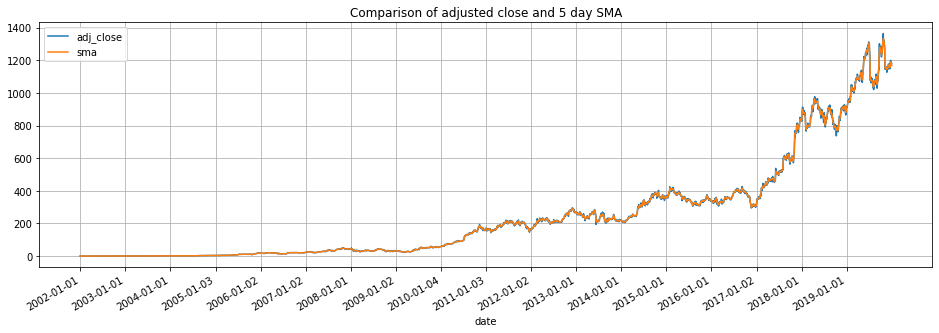

In [15]:
data[['adj_close', 'sma']].plot(figsize=(16,5), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Comparison of adjusted close and 5 day SMA');

Text(0.5, 1.0, 'Adjusted close price perecentile values grouped on yearly basis')

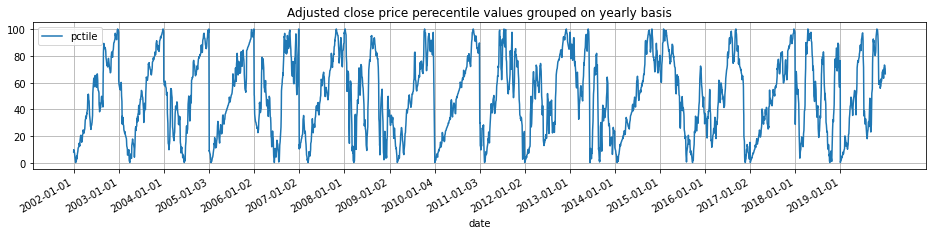

In [16]:
data[[pctile_col]].plot(figsize=(16,3), grid=True, xticks = data.groupby(group_by_col)[wd_col].idxmin())
plt.title('Adjusted close price perecentile values grouped on yearly basis')

In [17]:
years_of_data = len(year_agg_data) #len(data.index.year.unique())
print("Minimum", min_years_data_reqd, "years of historical data required for forecasting")  
print("Historical stocks data for", stock_ticker , "is available for", years_of_data, "years")
# Check min. years of data required for forecasting
if (years_of_data < min_years_data_reqd):    
    print("Historical stocks data for", stock_ticker, "is not sufficient for forecasting")

Minimum 8 years of historical data required for forecasting
Historical stocks data for TITAN is available for 18 years


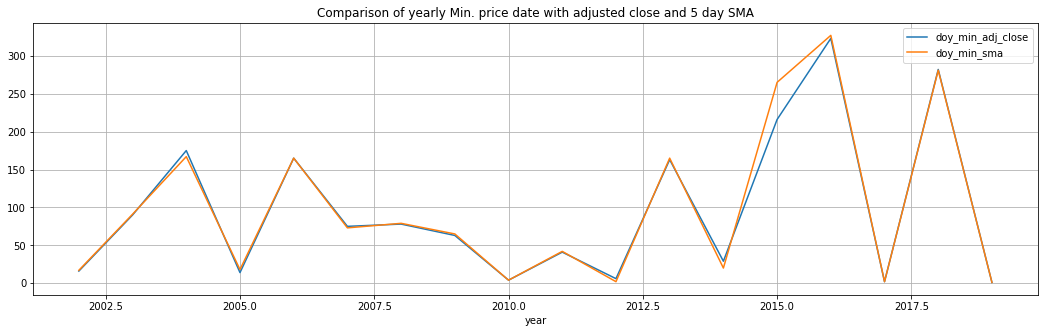

In [18]:
year_agg_data[['doy_min_adj_close', 'doy_min_sma']].plot(figsize=(18,5), grid=True)
plt.title('Comparison of yearly Min. price date with adjusted close and 5 day SMA');

## Build Train-Test Datasets

Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [19]:
frequency = int(round(len(data) / years_of_data, 0))
print('Average no. of records per year:', frequency)
cross_val = min(years_of_data - min_train_data_years, max_cross_val)
print('No. of cross validations, Test data period:', cross_val)
#test_data_years = min(years_of_data - min_train_data_years, max_cross_val)
#print('Test data period:', test_data_years, 'years')
train_data_years = len(year_agg_data) - cross_val
print('Train data period:', train_data_years, 'years')
split_year = current_year - cross_val
print('Cross validation begins from:', split_year)

Average no. of records per year: 247
No. of cross validations, Test data period: 5
Train data period: 13 years
Cross validation begins from: 2015


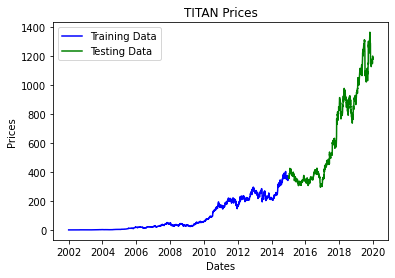

In [20]:
plt.figure(figsize=(6,4))
plt.title(stock_ticker + ' Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data[data.year < split_year] [agg_value_col], 'blue', label='Training Data')
plt.plot(data[data.year >= split_year] [agg_value_col], 'green', label='Testing Data')
plt.legend();

In [21]:
for i in range(cross_val):
    train_data = data[data.year < split_year + i] 
    test_data = data[data.year == split_year + i] 
    y_train = train_data[agg_value_col].values
    y_test = test_data[agg_value_col].values
    print(train_data.index.year.unique().values, test_data.index.year.unique().values)

[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014] [2015]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015] [2016]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016] [2017]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017] [2018]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018] [2019]


### Auto-correlation plots
Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

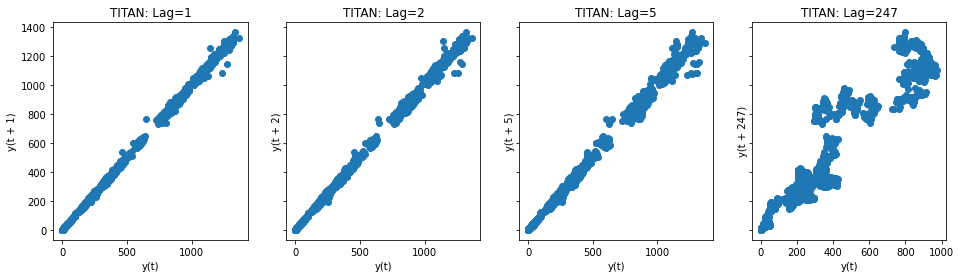

In [22]:
#from pandas.plotting import lag_plot
lags = [1, 2, 5, frequency]

fig, axes = plt.subplots(cnt_stocks, 4, squeeze=False, sharey='row'
                         , figsize=(16, 4*cnt_stocks))
plt.title('Autocorrelation plot')

for stk in range(cnt_stocks):
    for ax_col in range(4):
        axis = axes[stk][ax_col]
        pd.plotting.lag_plot(data[agg_value_col], lag=lags[ax_col], ax=axis)
        #axis.set_ylabel(stock_tickers[stk])
        axis.set_title(f"{stock_tickers[stk]}: Lag={lags[ax_col]}")

plt.show()

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

### Check for stationarity (Rolling mean and stdev)

In [23]:
data_series = data[agg_value_col]
data_diff = data_series.diff(periods=1).dropna(inplace = False)

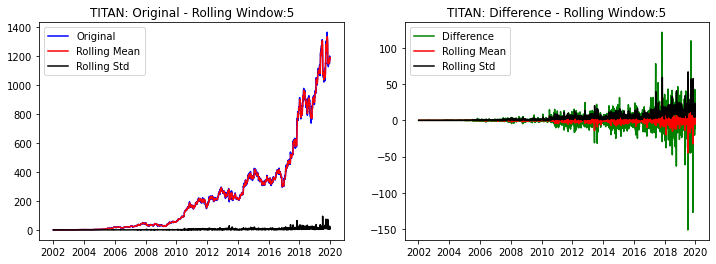

In [24]:
#Plot rolling statistics:
columns = 2
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(12, 4*cnt_stocks) )
plt.title('Rolling Mean & Standard Deviation');


for stk in range(cnt_stocks):
    axis = axes[stk][0]
    #Determing rolling statistics
    rolmean = data_series.rolling(eda_window).mean()
    rolstd = data_series.rolling(eda_window).std()
    orig = axis.plot(data_series, color='blue',label='Original')
    mean = axis.plot(rolmean, color='red', label='Rolling Mean')
    std = axis.plot(rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Original - Rolling Window:{eda_window}")
    
    ax_col = 1
    axis = axes[stk][ax_col]
    diff_rolmean = data_diff.rolling(eda_window).mean()
    diff_rolstd = data_diff.rolling(eda_window).std()
    diff = axis.plot(data_diff, color='green',label='Difference')
    diff_mean = axis.plot(diff_rolmean, color='red', label='Rolling Mean')
    diff_std = axis.plot(diff_rolstd, color='black', label = 'Rolling Std')
    axis.legend(loc='best')
    axis.set_title(f"{stock_tickers[stk]}: Difference - Rolling Window:{eda_window}")
    
plt.show()

### Augmented Dickey–Fuller test

In [25]:
adf_output = pd.DataFrame(index = ['Original','Difference'],
                      columns = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'
                                 , 'Critical Value (1%)', 'Critical Value (5%)' , 'Critical Value (10%)'])
adf_orig = adfuller(data_series, autolag='AIC')
adf_output.loc[adf_output.index[0]][0:4] = adf_orig[0:4]
adf_output.loc[adf_output.index[0]][4:7] = list(adf_orig[4].values())

adf_diff = adfuller(data_diff, autolag='AIC')
adf_output.loc[adf_output.index[1]][0:4] = adf_diff[0:4]
adf_output.loc[adf_output.index[1]][4:7] = list(adf_diff[4].values())
print('Output of ADF test')
adf_output

Output of ADF test


,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Original,1.81071,0.99837,31,4409,-3.43183,-2.8622,-2.56712
Difference,-12.9267,3.77528e-24,31,4408,-3.43183,-2.8622,-2.56712


If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. From the above statistics, we can observe that the p-value is very high for orignal data, which proves that our series is not stationary. To get stationary data, there are many techniques. We can use log, differencing and so on. 

<font color="orange">After differencing, the p-value is extremely small. Hence, it is evident that series becomes stationary after applying first order differencing</font>

Also Test Statistic is less than critical values, indicating stationarity.

##### Plot ACF and PACF on the original train series

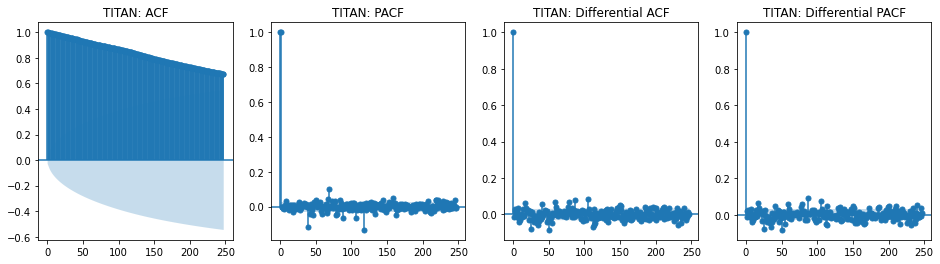

In [26]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Note:  Same is in pmdarima package via a wrapper function

columns = 4
fig, axes = plt.subplots(cnt_stocks, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*cnt_stocks) )
plt.title('ACF/PACF');

for stk in range(cnt_stocks):
    axis = axes[stk][0]
    plot_acf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: ACF")
    
    axis = axes[stk][1]
    plot_pacf(data_series, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: PACF")
    
    axis = axes[stk][2]
    plot_acf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential ACF")
    
    axis = axes[stk][3]
    plot_pacf(data_diff, ax=axis, lags=frequency)
    axis.set_title(f"{stock_tickers[stk]}: Differential PACF")
    
plt.show()

As per the above plots, stationarity is observed after 1 level of differentiation. 
<br>However, there is no definite trend observed to derive p,q and P,Q values for ARIMA model

### Get rolling yearly seasonality using Seasonal decompose

<br> For daily data with yearly sesonality, m = 365.25
<br> However in our case we have @245 records per year, hence, m = @245

In [27]:
sd_modes = ['additive', 'multiplicative']
sd_algos = ['sm', 'pmd']
sd_dict = {} 
for key in sd_algos: 
    for value in sd_modes: 
        sd_dict[f'{key}_{value[0:3]}'] = value 

start_from = split_year + 1 - min_train_data_years
sd_data = data[data.year >= start_from - 1][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(cross_val + min_train_data_years - 1):
    pred_year = start_from + i
    #print(pred_year)
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2010-01-04,2010,0.795702,-0.047036,1.135195,1.104129
2010-01-05,2010,1.101051,0.258873,1.138371,1.107253
2010-01-06,2010,1.140439,0.298496,1.133774,1.102805
2010-01-07,2010,1.523259,0.682192,1.145920,1.114626
2010-01-08,2010,0.791490,-0.045871,1.140100,1.109032
...,...,...,...,...,...
2018-12-24,2018,-3.243422,-2.348146,1.033870,1.016829
2018-12-26,2018,-3.501072,-2.934366,1.041982,1.020495
2018-12-27,2018,-5.042791,-3.192015,1.044336,1.028502


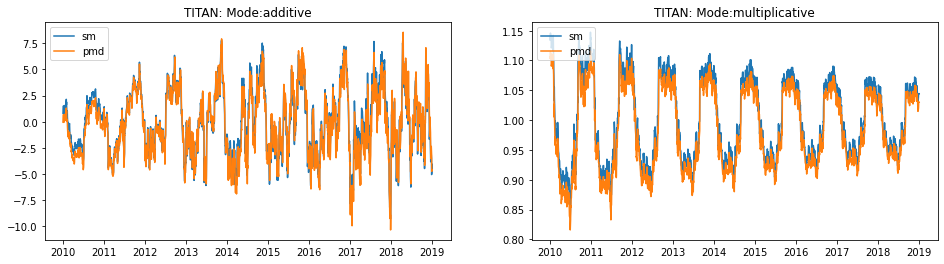

In [28]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [29]:
#Get yearwise min. price
sd_agg = sd_data.groupby(group_by_col).idxmin().dropna()
sd_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,2010-07-02,2010-07-02,2010-07-02,2010-07-02
2011,2011-03-23,2011-03-23,2011-06-29,2011-06-29
2012,2012-12-20,2012-12-21,2012-06-18,2012-06-19
2013,2013-06-28,2013-07-01,2013-06-20,2013-06-21
2014,2014-03-26,2014-03-27,2014-06-30,2014-07-01
2015,2015-01-14,2015-01-15,2015-06-24,2015-06-25
2016,2016-04-04,2016-04-05,2016-07-07,2016-07-08
2017,2017-12-26,2017-12-27,2017-06-28,2017-06-29
2018,2018-06-25,2018-06-26,2018-06-25,2018-06-26


In [30]:
#Get working day for given dates
def get_wd(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (wd_series[row[i]])
    #print(ref)
    return ref

#Get percentile of sma for given dates
def get_pctile(row):
    #print(row)
    ref = pd.Series(index = row.index)
    for i in range(len(row)):
        ref.loc[row.index[i]] = (pctile_series[row[i]])
    #print(ref)
    return ref

In [31]:

sd_output = sd_agg.apply(get_wd, axis = 1)
sd_output

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2010,124.0,124.0,124.0,124.0
2011,56.0,56.0,123.0,123.0
2012,239.0,240.0,115.0,116.0
2013,124.0,125.0,118.0,119.0
2014,59.0,60.0,123.0,124.0
2015,10.0,11.0,118.0,119.0
2016,63.0,64.0,127.0,128.0
2017,245.0,246.0,121.0,122.0
2018,120.0,121.0,120.0,121.0


In [32]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_rm = sd_output.rolling(min_train_data_years).mean().dropna()
#sd_refined = df * df.sub(df.rolling(5).mean()).div(df.rolling(5).std()).abs().lt(1.25)
sd_rm

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2014,120.4,121.0,120.6,121.2
2015,97.6,98.4,119.4,120.2
2016,99.0,100.0,120.2,121.2
2017,100.2,101.2,121.4,122.4
2018,99.4,100.4,121.8,122.8


In [33]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_refined = pd.DataFrame(columns = sd_rm.columns)
for i in range(cross_val):    
    pred_year = split_year + i
    #print(pred_year)    
    df = sd_output.loc[pred_year-5:pred_year-1]
    #print(df)
    #1.25 is the average ratio of error to deviation for marking outliers, TO - DO ignore std < 5
    #outlier_diff = 5
    #ref_df = df * df.sub(df.mean()).abs().lt(outlier_diff) - not the right way
    outlier_ratio = 1.25
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    ref_df = df * df.sub(df.mean()).div(df.std(), ).abs().lt(outlier_ratio)      
    #Replace 0 with NaN to ensure that outliers are ignored while calculating mean
    ref_df.replace(0, np.nan, inplace=True)
    #print(ref_df)
    #print(ref_df.mean())
    sd_refined = sd_refined.append(ref_df.mean(), ignore_index=True)

#Increment the year by 1 to indicate that this is the prediction for next year
sd_refined.index += split_year
#Add the actual output column - wd_min_sma
sd_refined = year_agg_data[['wd_min_sma']].join(sd_refined, how='inner')
#Rename column to indicate the correct interpretation
sd_refined.index.name = 'pred_year'
sd_refined

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015,181,90.75,91.25,122.0,122.50
2016,218,62.25,63.00,120.5,121.25
2017,1,64.00,65.00,118.5,119.50
2018,190,64.00,65.00,120.0,121.00
2019,1,63.00,64.00,120.5,121.50


In [34]:
#Get percentile from working day and year
def get_pctile_fron_wd(row):
    ref = row.copy()#pd.Series(index = row.index)
    #print(ref)
    year = row[0]
    #print(year)
    row = row[1:]
    #print(row)
    for i in range(len(row)):
        #print(row[i])
        ref.loc[row.index[i]] = data[(data.year == year) & (data[wd_col] == round(row[i], 0))].pctile[0]
    #print(ref)
    return ref

In [35]:
sd_pctile = sd_refined.reset_index()
sd_pctile = sd_pctile.apply(get_pctile_fron_wd, axis = 1)
sd_pctile.set_index('pred_year', inplace = True)
sd_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,,
2015.0,0.406504,59.756098,59.756098,49.593496,49.593496
2016.0,0.406504,26.829268,30.487805,70.731707,71.951220
2017.0,0.403226,30.241935,35.080645,45.967742,42.741935
2018.0,0.406504,84.552846,88.211382,36.991870,34.146341
2019.0,0.413223,44.214876,42.148760,96.694215,95.867769


## Holt Winters

In [36]:
hwes_trends = [None, 'additive', 'multiplicative']
hwes_modes = ['additive', 'multiplicative']
     
#hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col, agg_value_col_sma]]
hwes_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
hwes_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) 
#hwes_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']]##Update to use year_agg_data with mean values

#Running Holt Winters forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    #y_train = data[data.year < pred_year][[agg_value_col]]
    y_train = data[data.year < pred_year][agg_value_col]
    y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in hwes_modes:
        for trend in hwes_trends:
            #Excluding extreme scenario when both trend and seasonality are multiplicative
            if (mode != 'multiplicative' or trend != 'multiplicative' ):
                #forecasting
                #trend, seasonal: {“add”, “mul”, “additive”, “multiplicative”, None}, optional
                #initialization_method: None, ‘estimated’(Default), ‘heuristic’, ‘legacy-heuristic’, ‘known’  
                #use_boxcox{True, False, ‘log’, float}, optional
                hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
                #print(hwes_model.summary())
                hwes_forecast = hwes_model.forecast(steps=year_agg_data.loc[pred_year, 'record_cnt'])
                #print(hwes_forecast)
                if trend is None:
                     t = 'n'
                else:
                     t = trend[0]
                hwes_data.loc[y_test.index, 
                              f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = y_test.index) 
                #Set forecast metrics
                hwes_fcast_metrics.loc[pred_year, f'smape_hwes_t{t}_s{mode[0]}'] = smape(y_test, hwes_forecast)
                #mean_absolute_error(y_test, hwes_forecast)
                #sqrt(mean_squared_error(y_test, hwes_forecast)),
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
hwes_data, hwes_fcast_metrics

(            year    adj_close  hwes_tn_sa   hwes_ta_sa   hwes_tm_sa  \
 date                                                                  
 2015-01-01  2015   365.296967  367.160035   367.282504   367.661625   
 2015-01-02  2015   368.182404  367.246109   367.513304   368.289346   
 2015-01-05  2015   371.164032  367.668911   368.070764   369.273487   
 2015-01-06  2015   358.468140  367.813793   368.369156   369.985775   
 2015-01-07  2015   360.295593  367.441526   368.130473   370.163960   
 ...          ...          ...         ...          ...          ...   
 2019-12-24  2019  1195.029785  916.193961  1036.108749  1250.929658   
 2019-12-26  2019  1183.517090  915.922700  1036.317304  1252.155091   
 2019-12-27  2019  1182.474976  915.269363  1036.138153  1253.120353   
 2019-12-30  2019  1184.757690  916.036848  1037.388837  1255.568996   
 2019-12-31  2019  1179.001343  914.620422  1036.451806  1255.861231   
 
              hwes_tn_sm   hwes_ta_sm  
 date                 

As observed in HWES output, with both trend and sesonality set to multiplicative, the output shoots exponetially. Hence, ignore this case.

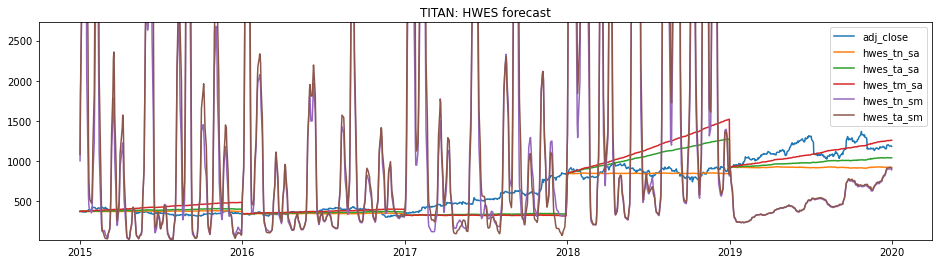

In [37]:
#Plot the HWES forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(hwes_data) 
    #Set ylimit for better visualization
    splt.set_ylim(hwes_data.min().min(), min(data[agg_value_col].max() * 2, hwes_data.max().max()))
    splt.legend(hwes_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

In [38]:
smape_avg = hwes_fcast_metrics.mean().sort_values(ascending=True)
print('Holt Winters Exponential Smoothing: Best output achieved with trend:', 
      smape_avg.index[0][-4], 'and seasonality:', smape_avg.index[0][-1])
smape_avg

Holt Winters Exponential Smoothing: Best output achieved with trend: n and seasonality: a


smape_hwes_tn_sa    18.018628
smape_hwes_ta_sa    19.593464
smape_hwes_tm_sa    22.179421
smape_hwes_tn_sm    83.256394
smape_hwes_ta_sm    88.725763
dtype: float64

## Auto Arima

###### Getting value of differencing term, d and seasonal differencing term, D

In [39]:
y_data = data[agg_value_col]

##directly estimate the number of differences required
kpss_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='adf', max_d=6)
pp_diffs = pm.arima.ndiffs(y_data, alpha=0.05, test='pp', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs, pp_diffs)

print(f"Estimated differencing term, d: {n_diffs}")

##directly estimate the number of seasonal differences
ocsb_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ocsb', max_D=6)
ch_sdiffs = pm.arima.nsdiffs(y_data, m=frequency, test='ch', max_D=6)
n_sdiffs = max(ocsb_sdiffs, ch_sdiffs)

print(f"Estimated seasonal differencing term, D: {n_sdiffs}")

Estimated differencing term, d: 2
Estimated seasonal differencing term, D: 0


###### Auto Arima forecasting

###### Training with yearly seasonality using FourierFeaturizer
As suggested in PMD Arima documentation - For long seasonal periods, we will use FourierFeaturizer as exogenous features

In [40]:
pmd_modes = ['ff', 'ff_date'] #, 'ff_exog', 'ff_exog_date'] 
date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
aa_fcast_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
#aa_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] # With mean value
aa_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) # Without mean value

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_prime, ff_data = trans.fit_transform(data[agg_value_col], exogenous=data[date_features])

#Running AutoARIMA forecasting for cross validation years
for i in range(cross_val):
    pred_year = split_year + i
    train_data = data[data.year < pred_year][[agg_value_col] + date_features]
    y_train = train_data[agg_value_col]
    test_data = data[data.year == pred_year][[agg_value_col] + date_features]
    y_test = test_data[agg_value_col] #data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    train_ff_data = ff_data[ff_data.year < pred_year]
    test_ff_data = ff_data[ff_data.year == pred_year]
    
    train_exog = None
    test_exog = None
    for mode in pmd_modes:
        if (mode == pmd_modes[0]):
            train_exog = train_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
            test_exog = test_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        else:
            train_exog = train_ff_data.copy()
            test_exog = test_ff_data.copy()
            
        #forecasting
        aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                         seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
        print('AutoArima Model order:', aa_model.order)
        #print(aa_model.summary())
        #aa_fcast, conf_int = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=True)
        aa_fcast = aa_model.predict(n_periods=len(y_test), exogenous=test_exog, return_conf_int=False)
        #print(aa_fcast)
        aa_fcast_data.loc[y_test.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = y_test.index) 
        #Derive forecast metrics
        aa_fcast_metrics.loc[pred_year, f'smape_aa_{mode}'] = smape(y_test, aa_fcast)
        print('Forecasting completed for', pred_year, 'mode:', mode, 'using ARIMA order:', aa_model.order)
        #Use break to stop execution after 1 loop for debugging
        #break        
    #break
        
aa_fcast_data, aa_fcast_metrics

AutoArima Model order: (6, 2, 0)
Forecasting completed for 2015 mode: ff using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2015 mode: ff_date using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2016 mode: ff using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2016 mode: ff_date using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2017 mode: ff using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2017 mode: ff_date using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2018 mode: ff using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2018 mode: ff_date using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 2019 mode: ff using ARIMA order: (6, 2, 0)
AutoArima Model order: (6, 2, 0)
Forecasting completed for 201

(            year    adj_close        aa_ff   aa_ff_date
 date                                                   
 2015-01-01  2015   365.296967   367.404575   368.492251
 2015-01-02  2015   368.182404   366.999628   368.024405
 2015-01-05  2015   371.164032   367.732134   368.816948
 2015-01-06  2015   358.468140   369.961404   370.968201
 2015-01-07  2015   360.295593   372.690624   373.641220
 ...          ...          ...          ...          ...
 2019-12-24  2019  1195.029785  2481.277256  2459.053707
 2019-12-26  2019  1183.517090  2487.616631  2465.503832
 2019-12-27  2019  1182.474976  2493.964598  2471.598816
 2019-12-30  2019  1184.757690  2500.323490  2478.286108
 2019-12-31  2019  1179.001343  2506.695509  2484.407278
 
 [1228 rows x 4 columns],
       smape_aa_ff  smape_aa_ff_date
 2015    47.145185         47.462658
 2016    92.269482         91.561462
 2017    23.505414         24.404684
 2018     5.254662          5.295949
 2019    37.767821         37.195467)

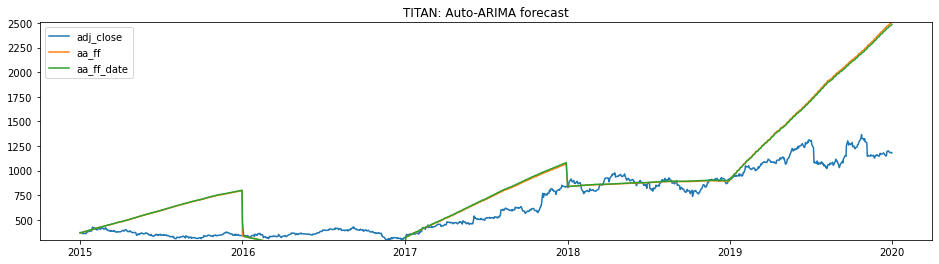

In [41]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_fcast_data.drop([group_by_col], axis = 1, inplace = True)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(aa_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(aa_fcast_data[agg_value_col].min(), min(data[agg_value_col].max() * 2, aa_fcast_data.max().max()))
    splt.legend(aa_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

In [42]:
aa_smape_avg = aa_fcast_metrics.mean().sort_values(ascending=True)
print('Auto-ARIMA with FourierFeaturizer - Best output achieved with:', aa_smape_avg.index[0])
aa_smape_avg

Auto-ARIMA with FourierFeaturizer - Best output achieved with: smape_aa_ff_date


smape_aa_ff_date    41.184044
smape_aa_ff         41.188513
dtype: float64

As observed in above plot and metrics, there is a significant improvement on adding exogenous features even with same data and model paramters

## Facebook Prophet

In [43]:
#Setting up dataset as per fbprophet requirements
pdata = pd.DataFrame() 
pdata['ds'] = data.index
pdata['y'] = data[agg_value_col].values

#Required for growth = "logistic"
pdata['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata

,ds,y,cap
0,2002-01-01,0.272359,2046.293701
1,2002-01-02,0.270913,2046.293701
2,2002-01-03,0.275976,2046.293701
3,2002-01-04,0.276338,2046.293701
4,2002-01-07,0.264040,2046.293701
...,...,...,...
4436,2019-12-24,1195.029785,2046.293701
4437,2019-12-26,1183.517090,2046.293701
4438,2019-12-27,1182.474976,2046.293701
4439,2019-12-30,1184.757690,2046.293701


In [44]:
#growth = "linear" or "logistic" to specify a linear or logistic trend.
#yearly.seasonality, weekly.seasonality, daily.seasonality  = "auto", TRUE, FALSE or a number of Fourier terms to generate.
#seasonality_mode = "additive" (default) or "multiplicative"
fb_growth = ['linear', 'logistic']
fb_smodes = ['additive', 'multiplicative']
     
fb_data = data[data.year >= split_year][[group_by_col, agg_value_col]]
fb_fcast_metrics = pd.DataFrame(index = [*range(split_year, current_year)]) ##years w/o mean values
#fb_fcast_metrics = year_agg_data[-cross_val:][['mean_adj_close']] ##years with mean values

#Running Prophet forecasting for cross validation years        
for i in range(cross_val):
    pred_year = split_year + i
    
    y_train = pdata[pdata.ds.dt.year < pred_year] 
    y_test = pdata[pdata.ds.dt.year == pred_year]  
    #y_train = data[data.year < pred_year][agg_value_col]
    #y_test = data[data.year == pred_year][agg_value_col]
    train_years = len(y_train.ds.dt.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in fb_smodes:
        for trend in fb_growth:
            t = trend[0:3]
            m = mode[0:3]
            fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
            fb_model.fit(y_train)
            fb_fcast = fb_model.predict(y_test)
            fb_data.loc[y_test.ds, f'fbp_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = y_test.ds) 
            fb_data.loc[y_test.ds, f'fbp_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = y_test.ds) 
            #Capture prediction metrics
            fb_fcast_metrics.loc[pred_year, f'smape_fbp_{t}_{m}'] = smape(y_test.y, fb_fcast.yhat)
            #mean_absolute_error(y_test.y, fb_fcast.yhat)
            #sqrt(mean_squared_error(y_test.y, fb_fcast.yhat))
            
            #Use break to stop execution after 1 loop for debugging
            #break
        #break
    #break
        
fb_data, fb_fcast_metrics

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

(            year    adj_close  fbp_lin_add  fbp_yearly_lin_add  fbp_log_add  \
 date                                                                          
 2015-01-01  2015   365.296967   317.254181           -3.493695   322.219685   
 2015-01-02  2015   368.182404   317.167099           -3.699525   322.160467   
 2015-01-05  2015   371.164032   316.930082           -4.292788   321.981035   
 2015-01-06  2015   358.468140   316.860280           -4.481338   321.922556   
 2015-01-07  2015   360.295593   316.795613           -4.664754   321.865843   
 ...          ...          ...          ...                 ...          ...   
 2019-12-24  2019  1195.029785  1088.168855           -4.903899  1166.164443   
 2019-12-26  2019  1183.517090  1089.313780           -4.831465  1167.907478   
 2019-12-27  2019  1182.474976  1089.913296           -4.768194  1168.802637   
 2019-12-30  2019  1184.757690  1091.794235           -4.495990  1171.529155   
 2019-12-31  2019  1179.001343  1092.441

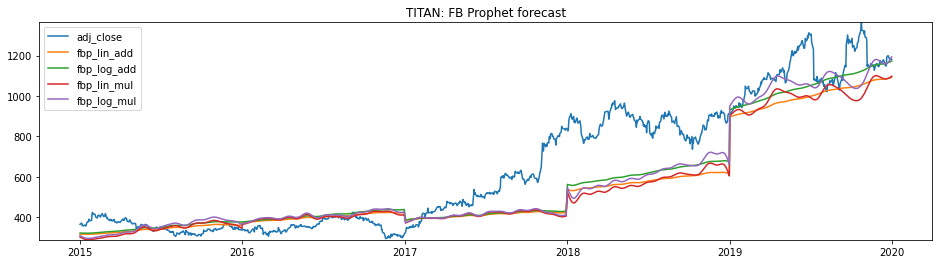

In [45]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('FB Prophet forecast output')

#Drop unwated columns from plot = year
fb_fcast_data = fb_data.drop(fb_data.filter(regex='year').columns, axis = 1)

for stk in range(cnt_stocks):    
    splt = axes[stk][0]                    
    splt.plot(fb_fcast_data) 
    #Set ylimit for better visualization
    splt.set_ylim(fb_fcast_data.min().min(), min(data[agg_value_col].max() * 2, fb_fcast_data.max().max()))
    splt.legend(fb_fcast_data.columns, loc='best')
    splt.set_title(f"{stock_tickers[stk]}: FB Prophet forecast")

plt.show()

In [46]:
fb_smape_avg = fb_fcast_metrics.mean().sort_values(ascending=True)
print('FB Prophet - Best output achieved with:', fb_smape_avg.index[0])
fb_smape_avg

FB Prophet - Best output achieved with: smape_fbp_log_add


smape_fbp_log_add    18.256097
smape_fbp_log_mul    19.057240
smape_fbp_lin_add    20.069874
smape_fbp_lin_mul    20.738080
dtype: float64

With all combinations, there is always as degradation observed with seasonality_mode = "multiplicative"

In [47]:
fcast_metrics = pd.concat([hwes_fcast_metrics, aa_fcast_metrics, fb_fcast_metrics], axis=1)
fcast_metrics

,smape_hwes_tn_sa,smape_hwes_ta_sa,smape_hwes_tm_sa,smape_hwes_tn_sm,smape_hwes_ta_sm,smape_aa_ff,smape_aa_ff_date,smape_fbp_lin_add,smape_fbp_log_add,smape_fbp_lin_mul,smape_fbp_log_mul
2015,8.153969,11.247707,19.362047,97.849696,108.246464,47.145185,47.462658,10.018972,10.766543,12.752637,13.674566
2016,8.344258,7.358057,7.402961,66.909575,69.937738,92.269482,91.561462,12.428268,14.396046,12.840893,14.476732
2017,47.798542,45.623526,49.056349,80.673415,90.302843,23.505414,24.404684,26.847017,26.090862,26.409356,25.704026
2018,5.778359,20.095958,27.609949,89.584506,94.979567,5.254662,5.295949,39.354511,32.837837,40.321631,34.157958
2019,20.018013,13.642072,7.465797,81.264777,80.162203,37.767821,37.195467,11.700602,7.189196,11.365881,7.272917


In [48]:
smape_avg = fcast_metrics.mean().sort_values(ascending=True)
print('Best price forecast output achieved with:', smape_avg.index[0])
smape_avg

Best price forecast output achieved with: smape_hwes_tn_sa


smape_hwes_tn_sa     18.018628
smape_fbp_log_add    18.256097
smape_fbp_log_mul    19.057240
smape_hwes_ta_sa     19.593464
smape_fbp_lin_add    20.069874
smape_fbp_lin_mul    20.738080
smape_hwes_tm_sa     22.179421
smape_aa_ff_date     41.184044
smape_aa_ff          41.188513
smape_hwes_tn_sm     83.256394
smape_hwes_ta_sm     88.725763
dtype: float64

Based on above results, best models for different algorithms are as follows:
<ul>
    <li>HWES: trend=None, seasonality mode ='add'</li>
    <li>AutoArima: Fourier Featurizer with date parts as exogenous features</li>
    <li>Prophet: yearly seasonality, logistic growth, seasonality mode ='add'</li>
</ul>

### Derive the best time of the year to invest based on price forecast

In [49]:
fcast_data = hwes_data.drop([agg_value_col]
                           , axis = 1).join(aa_fcast_data.drop([agg_value_col]
                                                               , axis = 1)).join(fb_data.drop([agg_value_col, group_by_col]
                                                                                              , axis = 1))
fcast_data

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015-01-01,367.160035,367.282504,367.661625,999.774255,1078.368767,367.404575,368.492251,317.254181,-3.493695,322.219685,-2.996992,303.347647,-0.046911,309.332262,-0.045326
2015-01-02,367.246109,367.513304,368.289346,1747.331396,1848.086475,366.999628,368.024405,317.167099,-3.699525,322.160467,-3.197254,302.029355,-0.051399,308.100702,-0.049543
2015-01-05,367.668911,368.070764,369.273487,2950.187418,3126.989723,367.732134,368.816948,316.930082,-4.292788,321.981035,-3.800119,298.233099,-0.064345,304.524592,-0.061809
2015-01-06,367.813793,368.369156,369.985775,4571.098394,4942.191138,369.961404,370.968201,316.860280,-4.481338,321.922556,-3.999841,297.054302,-0.068382,303.404328,-0.065670
2015-01-07,367.441526,368.130473,370.163960,6396.610423,7157.054588,372.690624,373.641220,316.795613,-4.664754,321.865843,-4.197848,295.934584,-0.072232,302.335321,-0.069369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,916.193961,1036.108749,1250.929658,896.167873,913.748518,2481.277256,2459.053707,1088.168855,-4.903899,1166.164443,-3.266342,1087.571658,-0.009686,1169.141876,-0.014169
2019-12-26,915.922700,1036.317304,1252.155091,898.591415,917.308164,2487.616631,2465.503832,1089.313780,-4.831465,1167.907478,-2.824707,1089.876994,-0.008561,1174.920501,-0.010405
2019-12-27,915.269363,1036.138153,1253.120353,897.856807,917.588768,2493.964598,2471.598816,1089.913296,-4.768194,1168.802637,-2.580065,1091.245489,-0.007804,1178.204957,-0.008193


In [50]:
fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1)

,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
date,,,,,,,,,,,,,,,
2015,31.0,11.0,1.0,73.0,143.0,2.0,2.0,12.0,21.0,12.0,21.0,14.0,15.0,14.0,15.0
2016,11.0,11.0,1.0,44.0,42.0,246.0,246.0,1.0,241.0,1.0,115.0,1.0,242.0,1.0,241.0
2017,12.0,12.0,245.0,44.0,242.0,1.0,1.0,1.0,243.0,1.0,242.0,1.0,243.0,1.0,243.0
2018,120.0,1.0,1.0,41.0,44.0,4.0,4.0,10.0,11.0,10.0,12.0,11.0,11.0,11.0,12.0
2019,200.0,1.0,1.0,24.0,24.0,1.0,1.0,1.0,189.0,1.0,189.0,1.0,191.0,1.0,191.0


In [51]:
wd_min_fcast = sd_refined.join(fcast_data.groupby([fcast_data.index.year]).idxmin().apply(get_wd, axis = 1))
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,181,90.75,91.25,122.0,122.50,31.0,11.0,1.0,73.0,143.0,2.0,2.0,12.0,21.0,12.0,21.0,14.0,15.0,14.0,15.0
2016,218,62.25,63.00,120.5,121.25,11.0,11.0,1.0,44.0,42.0,246.0,246.0,1.0,241.0,1.0,115.0,1.0,242.0,1.0,241.0
2017,1,64.00,65.00,118.5,119.50,12.0,12.0,245.0,44.0,242.0,1.0,1.0,1.0,243.0,1.0,242.0,1.0,243.0,1.0,243.0
2018,190,64.00,65.00,120.0,121.00,120.0,1.0,1.0,41.0,44.0,4.0,4.0,10.0,11.0,10.0,12.0,11.0,11.0,11.0,12.0
2019,1,63.00,64.00,120.5,121.50,200.0,1.0,1.0,24.0,24.0,1.0,1.0,1.0,189.0,1.0,189.0,1.0,191.0,1.0,191.0


In [52]:
output_mae = wd_min_fcast.apply(lambda x : abs(x - x['wd_min_sma']), axis=1).drop('wd_min_sma', axis = 1)
output_mae 

,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,
2015,90.25,89.75,59.0,58.50,150.0,170.0,180.0,108.0,38.0,179.0,179.0,169.0,160.0,169.0,160.0,167.0,166.0,167.0,166.0
2016,155.75,155.00,97.5,96.75,207.0,207.0,217.0,174.0,176.0,28.0,28.0,217.0,23.0,217.0,103.0,217.0,24.0,217.0,23.0
2017,63.00,64.00,117.5,118.50,11.0,11.0,244.0,43.0,241.0,0.0,0.0,0.0,242.0,0.0,241.0,0.0,242.0,0.0,242.0
2018,126.00,125.00,70.0,69.00,70.0,189.0,189.0,149.0,146.0,186.0,186.0,180.0,179.0,180.0,178.0,179.0,179.0,179.0,178.0
2019,62.00,63.00,119.5,120.50,199.0,0.0,0.0,23.0,23.0,0.0,0.0,0.0,188.0,0.0,188.0,0.0,190.0,0.0,190.0


In [53]:
best_mae = output_mae[-1:].transpose().sort_values(by=current_year-1, ascending=True)
best_mae #[:5]

pred_year,2019
aa_ff,0.0
fbp_lin_mul,0.0
fbp_log_add,0.0
fbp_lin_add,0.0
aa_ff_date,0.0
hwes_ta_sa,0.0
hwes_tm_sa,0.0
fbp_log_mul,0.0
hwes_tn_sm,23.0
hwes_ta_sm,23.0


In [54]:
print('Top 5 best sesonality forecast for 2019 for', stock_ticker, ':\n', best_mae.index[0:5])

Top 5 best sesonality forecast for 2019 for TITAN :
 Index(['aa_ff', 'fbp_lin_mul', 'fbp_log_add', 'fbp_lin_add', 'aa_ff_date'], dtype='object')


Top models for each technique:
<ol>
    <li>FB Prophet yearly pattern (Seasonality: Additive): <font color="red">0 days</font></li>
    <li>FB Prophet (Seasonality: Multiplicative): <font color="red">1 day</font></li>
    <li>AutoArima (using Fourier Featurizer): <font color="red">1 day</font></li>
    <li>HWES (Seasonality: Additive): <font color="red">4 days</font></li>
    <li>Seasonal decompose (Seasonality: Additive): <font color="red">6.4 days</font></li>
</ol>

In [55]:
#Threshold for accuracy = 10 days
threshold = 15
output_mae.loc[:, output_mae[output_mae <= threshold].count() >= 3]

""
pred_year
2015
2016
2017
2018
2019


In [56]:
accurate_mae = output_mae[ output_mae <= threshold ].count()
consistent = accurate_mae[accurate_mae > 2].sort_values(ascending = False)

In [57]:
print('Algorithms with most accurate forecast for last 5 years', stock_ticker, ':\n', consistent[0:3])

Algorithms with most accurate forecast for last 5 years TITAN :
 Series([], dtype: int64)


### Accuracy based on Percentile of price 

In [58]:
wd_min_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,181,90.75,91.25,122.0,122.50,31.0,11.0,1.0,73.0,143.0,2.0,2.0,12.0,21.0,12.0,21.0,14.0,15.0,14.0,15.0
2016,218,62.25,63.00,120.5,121.25,11.0,11.0,1.0,44.0,42.0,246.0,246.0,1.0,241.0,1.0,115.0,1.0,242.0,1.0,241.0
2017,1,64.00,65.00,118.5,119.50,12.0,12.0,245.0,44.0,242.0,1.0,1.0,1.0,243.0,1.0,242.0,1.0,243.0,1.0,243.0
2018,190,64.00,65.00,120.0,121.00,120.0,1.0,1.0,41.0,44.0,4.0,4.0,10.0,11.0,10.0,12.0,11.0,11.0,11.0,12.0
2019,1,63.00,64.00,120.5,121.50,200.0,1.0,1.0,24.0,24.0,1.0,1.0,1.0,189.0,1.0,189.0,1.0,191.0,1.0,191.0


In [59]:
fcast_pctile = wd_min_fcast.reset_index()
fcast_pctile = fcast_pctile.apply(get_pctile_fron_wd, axis = 1)
fcast_pctile.set_index('pred_year', inplace = True)
fcast_pctile

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,59.756098,59.756098,49.593496,49.593496,95.934959,68.699187,69.918699,78.861789,15.853659,69.105691,69.105691,73.170732,100.000000,73.170732,100.000000,79.268293,80.894309,79.268293,80.894309
2016.0,0.406504,26.829268,30.487805,70.731707,71.951220,21.138211,21.138211,36.991870,19.105691,15.853659,15.447154,15.447154,36.991870,3.658537,36.991870,65.853659,36.991870,2.845528,36.991870,3.658537
2017.0,0.403226,30.241935,35.080645,45.967742,42.741935,4.838710,4.838710,98.790323,16.532258,99.596774,0.403226,0.403226,0.403226,100.000000,0.403226,99.596774,0.403226,100.000000,0.403226,100.000000
2018.0,0.406504,84.552846,88.211382,36.991870,34.146341,36.991870,28.861789,28.861789,15.853659,12.601626,45.528455,45.528455,61.382114,57.723577,61.382114,55.691057,57.723577,57.723577,57.723577,55.691057
2019.0,0.413223,44.214876,42.148760,96.694215,95.867769,97.933884,0.413223,0.413223,9.917355,9.917355,0.413223,0.413223,0.413223,80.991736,0.413223,80.991736,0.413223,84.297521,0.413223,84.297521


In [60]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast = wd_min_fcast * fcast_pctile.copy().apply(lambda x : x < pctile_threshold)
accurate_fcast.replace(0, np.nan, inplace = True)
accurate_fcast

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.0,42.0,246.0,246.0,NaN,241.0,NaN,NaN,NaN,242.0,NaN,241.0
2017,1,NaN,NaN,NaN,NaN,12.0,12.0,NaN,44.0,NaN,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN
2018,190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,24.0,24.0,1.0,1.0,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN


In [61]:
#Check to see if Predicted min. work day price was actually in lower 20 percentile of the yearly price variations
pctile_threshold = 20
wd_min_fcast.loc[:, fcast_pctile[fcast_pctile <= pctile_threshold].count() >= 3]

,wd_min_sma,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date
pred_year,,,,,
2015,181,73.0,143.0,2.0,2.0
2016,218,44.0,42.0,246.0,246.0
2017,1,44.0,242.0,1.0,1.0
2018,190,41.0,44.0,4.0,4.0
2019,1,24.0,24.0,1.0,1.0


In [62]:
fcast_pctile[fcast_pctile <= pctile_threshold]

,wd_min_sma,sm_add,pmd_add,sm_mul,pmd_mul,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fbp_lin_add,fbp_yearly_lin_add,fbp_log_add,fbp_yearly_log_add,fbp_lin_mul,fbp_yearly_lin_mul,fbp_log_mul,fbp_yearly_log_mul
pred_year,,,,,,,,,,,,,,,,,,,,
2015.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.853659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.105691,15.853659,15.447154,15.447154,NaN,3.658537,NaN,NaN,NaN,2.845528,NaN,3.658537
2017.0,0.403226,NaN,NaN,NaN,NaN,4.83871,4.838710,NaN,16.532258,NaN,0.403226,0.403226,0.403226,NaN,0.403226,NaN,0.403226,NaN,0.403226,NaN
2018.0,0.406504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.853659,12.601626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019.0,0.413223,NaN,NaN,NaN,NaN,NaN,0.413223,0.413223,9.917355,9.917355,0.413223,0.413223,0.413223,NaN,0.413223,NaN,0.413223,NaN,0.413223,NaN


In [63]:
top_algos = fcast_pctile[fcast_pctile <= pctile_threshold].count()[1:].sort_values(ascending = False)
top_algos

hwes_tn_sm            4
hwes_ta_sm            4
aa_ff                 3
aa_ff_date            3
fbp_lin_mul           2
hwes_ta_sa            2
fbp_log_add           2
fbp_lin_add           2
fbp_log_mul           2
hwes_tn_sa            1
hwes_tm_sa            1
fbp_yearly_log_mul    1
fbp_yearly_lin_add    1
fbp_yearly_lin_mul    1
fbp_yearly_log_add    0
pmd_mul               0
sm_mul                0
pmd_add               0
sm_add                0
dtype: int64

In [64]:
print('Best results for', stock_ticker, 'stock with each of the 5 algorithms are as follows:')
print('Method: ', top_algos.filter(regex='^hwes_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^hwes_')[0])
print('Method: ', top_algos.filter(regex='^aa_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^aa_')[0])
print('Method: ', top_algos.filter(regex='^fbp_l').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_l')[0])
print('Method: ', top_algos.filter(regex='^fbp_y').index[0], 'Correct predicted years: ', top_algos.filter(regex='^fbp_y')[0])
print('Method: ', top_algos.filter(regex='^sm_').index[0], 'Correct predicted years: ', top_algos.filter(regex='^sm_')[0])

Best results for TITAN stock with each of the 5 algorithms are as follows:
Method:  hwes_tn_sm Correct predicted years:  4
Method:  aa_ff Correct predicted years:  3
Method:  fbp_lin_mul Correct predicted years:  2
Method:  fbp_yearly_log_mul Correct predicted years:  1
Method:  sm_mul Correct predicted years:  0


In [65]:
end = time.time()
print('Analyzing data took ' + str(round((end - start), 3)) + ' seconds for ' + stock_ticker + '.')  

Analyzing data took 2533.929 seconds for TITAN.


### Prediction for current year
Using top 5 best models

In [66]:
y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

##### Generate current year data set

In [91]:
trading_holidays = ['2020-02-21', '2020-03-10', '2020-04-02', '2020-04-06', '2020-04-10', '2020-04-14'
                    , '2020-05-01', '2020-05-25', '2020-10-02', '2020-11-16', '2020-11-30', '2020-12-25'] 
pred_dates = pd.date_range(datetime.datetime(current_year, 1, 1), 
                           datetime.datetime(current_year, 12, 31), 
                           freq=pd.tseries.offsets.BDay()).to_frame(index=False, name = 'ds')
pred_dates = pred_dates[~pred_dates.ds.isin(trading_holidays)]
print('No. of working days in', current_year, ':', len(pred_dates))
pred_dates.reset_index(drop = True, inplace = True)
pred_dates.index += 1
pred_dates.index.names = ['work_doy']
pred_dates

No. of working days in 2020 : 250


,ds
work_doy,
1,2020-01-01
2,2020-01-02
3,2020-01-03
4,2020-01-06
5,2020-01-07
...,...
246,2020-12-24
247,2020-12-28
248,2020-12-29


##### Using Seasonal Decompose

In [92]:
sd_pred_data = data[data.year >= split_year][[group_by_col]]

#Running seasonal_decompose for cross validation years        
for i in range(min_train_data_years):
    till_year = split_year + i
    #print(till_year)
    #y_train = data[data.year <= till_year][[agg_value_col]]
    y_train = data[data.year <= till_year][agg_value_col]
    train_years = len(y_train.index.year.unique())
    freq = int(round((len(y_train) / train_years), 0))
    
    for mode in sd_modes:
        #seasonal_decompose using statsmodels package
        sd = seasonal_decompose(y_train, model=mode, period=freq)
        latest_year_cnt = len(data[data.year == y_train.index.year.max()])
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'sm_{mode[0:3]}'] = pd.Series(sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])  
        #seasonal_decompose using pmdarima package
        pmd_sd = pm.arima.decompose(y_train.values, type_=mode, m=freq, filter_=None)
        sd_pred_data.loc[y_train.index[-latest_year_cnt:], f'pmd_{mode[0:3]}'] = pd.Series(pmd_sd.seasonal[-latest_year_cnt:], index = y_train.index[-latest_year_cnt:])
               
sd_pred_data.dropna()

,year,sm_add,pmd_add,sm_mul,pmd_mul
date,,,,,
2015-01-01,2015,-3.413752,-3.010918,1.056810,1.039481
2015-01-02,2015,-3.105237,-3.056776,1.065202,1.042344
2015-01-05,2015,-2.444604,-2.748261,1.071927,1.050621
2015-01-06,2015,-3.261830,-2.087629,1.068706,1.057254
2015-01-07,2015,-3.489225,-2.904855,1.058374,1.054077
...,...,...,...,...,...
2019-12-24,2019,-4.993257,-3.365283,1.040338,1.032557
2019-12-26,2019,-5.342092,-5.024279,1.036953,1.026972
2019-12-27,2019,-6.080886,-5.373114,1.031463,1.023631


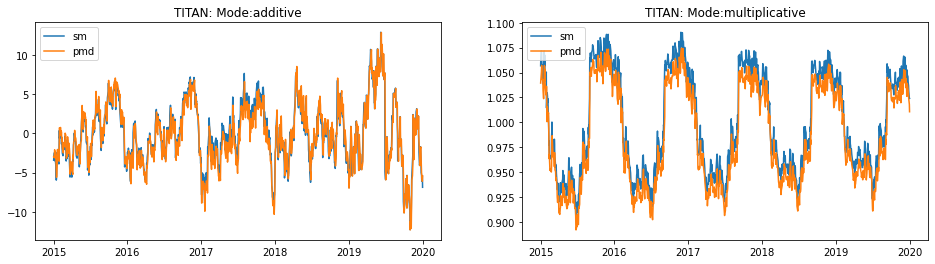

In [93]:
#Plot the Seasonal decompose output:
columns = len(sd_modes)
rows = cnt_stocks
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Seasonal decompose output');

for stk in range(cnt_stocks):
    for m in range(columns):
        sp = axes[stk][m]
        key = f'_{sd_modes[m][0:3]}'            
        sp.plot(sd_pred_data.filter(regex=key, axis=1))            
        sp.legend(sd_algos, loc='upper left')
        sp.set_title(f"{stock_tickers[stk]}: Mode:{sd_modes[m]}")

plt.show()

In [94]:
#Get yearwise min. price
sd_pred_agg = sd_pred_data.groupby(group_by_col).idxmin().dropna().apply(get_wd, axis = 1)
sd_pred_agg

,sm_add,pmd_add,sm_mul,pmd_mul
year,,,,
2015,10.0,11.0,118.0,119.0
2016,63.0,64.0,127.0,128.0
2017,245.0,246.0,121.0,122.0
2018,120.0,121.0,120.0,121.0
2019,200.0,201.0,121.0,122.0


In [95]:
#Get avg. seasonality for last 5 years w/o ignoring the outlier to show the diff. betn. with and w/o outliers
sd_pred_agg.mean()

sm_add     127.6
pmd_add    128.6
sm_mul     121.4
pmd_mul    122.4
dtype: float64

In [96]:
#Get avg. seasonality for last 5 years while ignoring the outlier years
sd_pred_ref = pd.DataFrame(index = [current_year], columns = sd_pred_agg.columns)
df = sd_pred_agg.copy()
#1.25 is the average ratio of error to deviation for marking outliers
outlier_ratio = 1.25
#print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
#Doesn't matter even if some values are dropped in case of lower std below 5
ref_df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
   
#Replace 0 with NaN to ensure that outliers are ignored while calculating mean
ref_df.replace(0, np.nan, inplace=True)
#print(ref_df)
#print(ref_df.mean())
sd_pred_ref.loc[current_year] = round(ref_df.mean(), 0)

#Rename column to indicate the correct interpretation
sd_pred_ref.index.name = 'pred_year'
sd_pred_ref

,sm_add,pmd_add,sm_mul,pmd_mul
pred_year,,,,
2020,128,129,120,121


##### Using HWES

In [97]:
pred_data = pred_dates.copy()

y_train = data[agg_value_col]
train_years = len(y_train.index.year.unique())
freq = int(round((len(y_train) / train_years), 0))

In [98]:
for mode in hwes_modes:
    for trend in hwes_trends:
        #Excluding extreme scenario when both trend and seasonality are multiplicative
        if (mode != 'multiplicative' or trend != 'multiplicative' ):
            hwes_model = HWES(y_train, seasonal_periods=freq, trend=trend, seasonal=mode).fit()            
            #print(hwes_model.summary())
            hwes_forecast = hwes_model.forecast(steps=len(pred_data))
            #print(hwes_forecast)
            if trend is None:
                 t = 'n'
            else:
                 t = trend[0]
            pred_data.loc[pred_data.index, 
                          f'hwes_t{t}_s{mode[0]}'] = pd.Series(hwes_forecast.values, index = pred_data.index) 
        #Use break to stop execution after 1 loop for debugging
        #break
    #break
        
pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm
work_doy,,,,,,
1,2020-01-01,1178.369678,1178.265406,1177.979706,1170.433405,1170.266405
2,2020-01-02,1179.748288,1179.254107,1178.479294,1182.027376,1182.067943
3,2020-01-03,1178.115912,1178.246656,1177.094187,1178.522354,1178.066721
4,2020-01-06,1179.945443,1180.887801,1179.195852,1200.694823,1199.149392
5,2020-01-07,1179.889380,1182.258469,1180.000726,1216.319795,1213.463121
...,...,...,...,...,...,...
246,2020-12-24,1180.167704,1325.970452,1206.954839,1190.540095,1214.590759
247,2020-12-28,1179.078520,1325.303161,1205.918428,1177.189809,1201.293437
248,2020-12-29,1178.369678,1324.527123,1204.708371,1170.433405,1194.235677


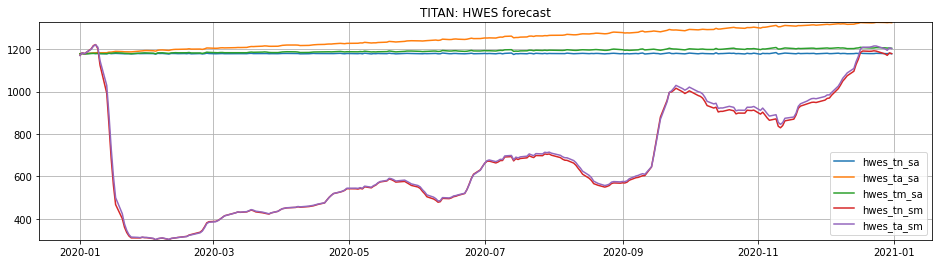

In [99]:
#Plot the HWES forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('HWES forecast output')

#Drop unwated columns from plot = year
hwes_plot = pred_data.drop(['ds'], axis = 1)

splt = axes[0][0]                    
splt.plot(pred_data['ds'], hwes_plot) 
splt.grid(True)
#Set ylimit for better visualization
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

plt.show()

##### Using AutoArima

In [100]:
ff_data.tail()

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S247-0,FOURIER_C247-0,FOURIER_S247-1,FOURIER_C247-1,FOURIER_S247-2,FOURIER_C247-2,FOURIER_S247-3,FOURIER_C247-3
4436,2019,12,52,1,24,358,-0.226945,0.973908,-0.442047,0.896992,-0.634075,0.773272,-0.793026,0.609188
4437,2019,12,52,3,26,360,-0.202100,0.979365,-0.395860,0.918311,-0.573275,0.819363,-0.727045,0.686590
4438,2019,12,52,4,27,361,-0.177124,0.984188,-0.348648,0.937254,-0.509139,0.860685,-0.653543,0.756890
4439,2019,12,53,0,30,364,-0.152034,0.988375,-0.300533,0.953771,-0.442038,0.896996,-0.573280,0.819359
4440,2019,12,53,1,31,365,-0.126845,0.991923,-0.251641,0.967821,-0.372365,0.928087,-0.487087,0.873353


In [101]:
#date_features = ["year","month","week","day_of_week","day_of_month","day_of_year"]
future_algo = 'hwes_tn_sa' #Any of the other algorithm outputs as exogenous input for ARIMAX
exog_data = pred_dates.copy()
#exog_data.reset_index(inplace = True) #Uncomment if work day is required
exog_data.set_index('ds', inplace = True)
exog_data['year'] = exog_data.index.year
exog_data["month"] = exog_data.index.month
exog_data['week'] = pd.Int64Index(exog_data.index.isocalendar().week) #Deprecated - rawdf.index.week/weekofyear
exog_data["day_of_week"] = exog_data.index.dayofweek
exog_data["day_of_month"] = exog_data.index.day
exog_data['day_of_year'] = exog_data.index.dayofyear
#Handle ISO week format for last days of year marked as Week 1
exog_data.loc[(exog_data['week'] == 1) & (exog_data['day_of_year'] > 350),'week'] = 53 
#print(exog_data)

#FourierFeaturizer
trans = pm.preprocessing.FourierFeaturizer(m=frequency, k=4) #k = no. of Sin/Cos terms - columns = k*2
y_future, future_ff_data = trans.fit_transform(pred_data[future_algo], exogenous=exog_data[date_features])

future_ff_data

,year,month,week,day_of_week,day_of_month,day_of_year,FOURIER_S247-0,FOURIER_C247-0,FOURIER_S247-1,FOURIER_C247-1,FOURIER_S247-2,FOURIER_C247-2,FOURIER_S247-3,FOURIER_C247-3
0,2020,1,1,2,1,1,2.543525e-02,0.999676,5.085405e-02,0.998706,7.623994e-02,0.997090,1.015765e-01,0.994828
1,2020,1,1,3,2,2,5.085405e-02,0.998706,1.015765e-01,0.994828,1.520361e-01,0.988375,2.021022e-01,0.979364
2,2020,1,1,4,3,3,7.623994e-02,0.997090,1.520361e-01,0.988375,2.269472e-01,0.973907,3.005373e-01,0.953770
3,2020,1,2,0,6,6,1.015765e-01,0.994828,2.021022e-01,0.979364,3.005373e-01,0.953770,3.958635e-01,0.918309
4,2020,1,2,1,7,7,1.268473e-01,0.991922,2.516454e-01,0.967820,3.723780e-01,0.928081,4.870946e-01,0.873349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020,12,52,3,24,359,-2.543514e-02,0.999676,-5.085382e-02,0.998706,-7.623915e-02,0.997090,-1.015760e-01,0.994828
246,2020,12,53,0,28,363,1.133783e-07,1.000000,2.267565e-07,1.000000,8.002082e-07,1.000000,4.535131e-07,1.000000
247,2020,12,53,1,29,364,2.543537e-02,0.999676,5.085428e-02,0.998706,7.624074e-02,0.997089,1.015770e-01,0.994828
248,2020,12,53,2,30,365,5.085416e-02,0.998706,1.015767e-01,0.994828,1.520369e-01,0.988375,2.021027e-01,0.979364


In [102]:
train_exog = None
test_exog = None
for mode in pmd_modes:
    if (mode == pmd_modes[0]):
        train_exog = ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
        test_exog = future_ff_data.drop(date_features, axis=1)#Drop other exogenous features if, added
    else:
        train_exog = ff_data.copy()
        test_exog = future_ff_data.copy()

    #forecasting
    aa_model = pm.auto_arima(y_train, exogenous=train_exog, d=n_diffs, max_p=6, 
                     seasonal=False, stepwise=True, suppress_warnings=True, trace=False)
    #print('AutoArima Model order:', aa_model.order)
    #print(aa_model.summary())
    aa_fcast, conf_int = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=True)
    #aa_fcast = aa_model.predict(n_periods=len(pred_data), exogenous=test_exog, return_conf_int=False)
    #print(aa_fcast)
    pred_data.loc[pred_data.index, f'aa_{mode}'] = pd.Series(aa_fcast, index = pred_data.index) 
#Use break to stop execution after 1 loop for debugging        
#break

pred_data

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date
work_doy,,,,,,,,
1,2020-01-01,1178.369678,1178.265406,1177.979706,1170.433405,1170.266405,1183.810699,1184.182777
2,2020-01-02,1179.748288,1179.254107,1178.479294,1182.027376,1182.067943,1182.605689,1182.738320
3,2020-01-03,1178.115912,1178.246656,1177.094187,1178.522354,1178.066721,1180.174588,1180.165328
4,2020-01-06,1179.945443,1180.887801,1179.195852,1200.694823,1199.149392,1178.065049,1178.594895
5,2020-01-07,1179.889380,1182.258469,1180.000726,1216.319795,1213.463121,1177.099087,1177.436346
...,...,...,...,...,...,...,...,...
246,2020-12-24,1180.167704,1325.970452,1206.954839,1190.540095,1214.590759,951.825013,936.410384
247,2020-12-28,1179.078520,1325.303161,1205.918428,1177.189809,1201.293437,950.786775,936.033114
248,2020-12-29,1178.369678,1324.527123,1204.708371,1170.433405,1194.235677,949.742697,934.795933


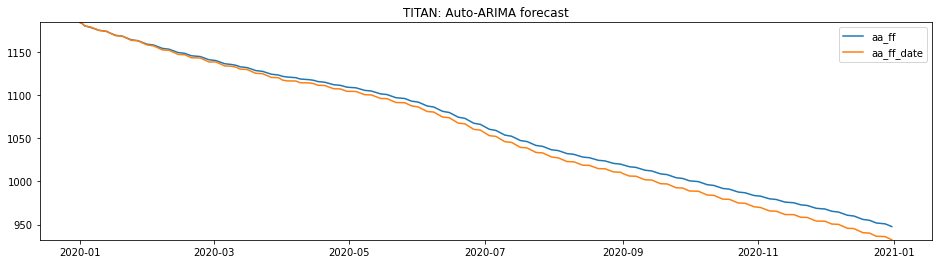

In [103]:
#Plot the Auto-ARIMA forecast output:
columns = 1
rows = 1
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title('Auto-ARIMA with FourierFeaturizer forecast output')

#Drop unwated columns from plot = year
aa_plot = pred_data.filter(regex = '^aa_', axis = 1) #regex filter for aa

splt = axes[0][0]                    
splt.plot(pred_data['ds'], aa_plot) 
#Set ylimit for better visualization
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

plt.show()

##### Using FB Prophet

In [104]:
pred_dates_cap = pred_dates.copy()
#Required for growth = "logistic"
pred_dates_cap['cap'] = 1.5 * pdata.y.max() #Capping the price growth at 50% of max. value

pdata.head(), pred_dates_cap.head()

(          ds         y          cap
 0 2002-01-01  0.272359  2046.293701
 1 2002-01-02  0.270913  2046.293701
 2 2002-01-03  0.275976  2046.293701
 3 2002-01-04  0.276338  2046.293701
 4 2002-01-07  0.264040  2046.293701,
                  ds          cap
 work_doy                        
 1        2020-01-01  2046.293701
 2        2020-01-02  2046.293701
 3        2020-01-03  2046.293701
 4        2020-01-06  2046.293701
 5        2020-01-07  2046.293701)

In [105]:
for mode in fb_smodes:
    for trend in fb_growth:
        t = trend[0:3]
        m = 's' + mode[0:1]
        fb_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, growth=trend, seasonality_mode=mode)
        fb_model.fit(pdata)
        fb_fcast = fb_model.predict(pred_dates_cap)
        pred_data.loc[pred_data.index, f'fb_yhat_{t}_{m}'] = pd.Series(fb_fcast.yhat.values, index = pred_data.index) 
        pred_data.loc[pred_data.index, f'fb_yearly_{t}_{m}'] = pd.Series(fb_fcast.yearly.values, index = pred_data.index) 
        
        #Use break to stop execution after 1 loop for debugging
        #break
    #break        
pred_data

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
work_doy,,,,,,,,,,,,,,,,
1,2020-01-01,1178.369678,1178.265406,1177.979706,1170.433405,1170.266405,1183.810699,1184.182777,1244.081709,-6.128652,1265.429613,-5.354600,1227.751156,-0.024617,1252.402776,-0.025939
2,2020-01-02,1179.748288,1179.254107,1178.479294,1182.027376,1182.067943,1182.605689,1182.738320,1245.300989,-5.638379,1266.671067,-4.870988,1231.589811,-0.022142,1256.947944,-0.022993
3,2020-01-03,1178.115912,1178.246656,1177.094187,1178.522354,1178.066721,1180.174588,1180.165328,1246.518613,-5.149761,1267.896848,-4.402760,1235.426272,-0.019670,1261.461345,-0.020075
4,2020-01-06,1179.945443,1180.887801,1179.195852,1200.694823,1199.149392,1178.065049,1178.594895,1250.102199,-3.753195,1271.430286,-3.140236,1246.543959,-0.012584,1274.374700,-0.011826
5,2020-01-07,1179.889380,1182.258469,1180.000726,1216.319795,1213.463121,1177.099087,1177.436346,1251.256349,-3.328052,1272.547353,-2.779556,1250.007422,-0.010419,1278.343940,-0.009343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2020-12-24,1180.167704,1325.970452,1206.954839,1190.540095,1214.590759,951.825013,936.410384,1502.059207,-9.135504,1509.993800,-8.719399,1462.476397,-0.039801,1468.721603,-0.044734
247,2020-12-28,1179.078520,1325.303161,1205.918428,1177.189809,1201.293437,950.786775,936.033114,1506.456115,-7.654623,1514.217243,-6.957254,1476.748932,-0.032307,1485.682883,-0.035256
248,2020-12-29,1178.369678,1324.527123,1204.708371,1170.433405,1194.235677,949.742697,934.795933,1507.635596,-7.204148,1515.321392,-6.467253,1480.926653,-0.030038,1490.560241,-0.032477


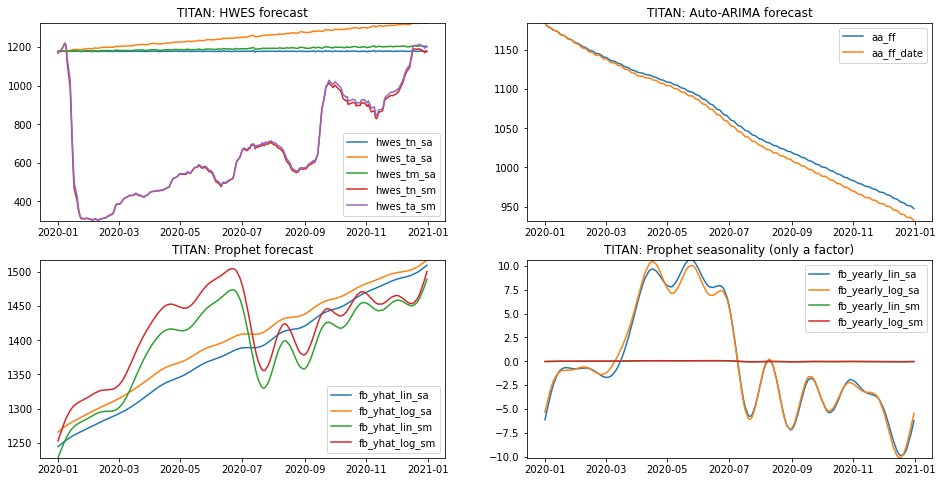

In [106]:
#Plot the forecast output:
columns = 2
rows = 2
fig, axes = plt.subplots(rows, columns, squeeze=False, #sharey='row',
                             figsize=(16, 4*rows) )
plt.title(f"{stock_tickers[stk]}: Time series forecast output")

splt = axes[0][0]     
hwes_plot = pred_data.filter(regex = '^hwes_', axis = 1) #regex filter for hwes
splt.plot(pred_data['ds'], hwes_plot)
splt.set_ylim(hwes_plot.min().min(), min(data[agg_value_col].max() * 2, hwes_plot.max().max()))
splt.legend(hwes_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: HWES forecast")

splt = axes[0][1]    
aa_plot = pred_data.filter(regex = '^aa_', axis = 1)#regex filter for autoarima
splt.plot(pred_data['ds'], aa_plot) 
splt.set_ylim(aa_plot.min().min(), min(data[agg_value_col].max() * 2, aa_plot.max().max()))
splt.legend(aa_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Auto-ARIMA forecast")

splt = axes[1][0]     
fb_plot = pred_data.filter(regex = '^fb_yhat_', axis = 1) #regex filter for fb prediction
splt.plot(pred_data['ds'], fb_plot)
splt.set_ylim(fb_plot.min().min(), min(data[agg_value_col].max() * 2, fb_plot.max().max()))
splt.legend(fb_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet forecast")

splt = axes[1][1]    
fb_yr_plot = pred_data.filter(regex = '^fb_yearly_', axis = 1)#regex filter for fb seasonality
splt.plot(pred_data['ds'], fb_yr_plot) 
splt.set_ylim(fb_yr_plot.min().min(), min(data[agg_value_col].max() * 2, fb_yr_plot.max().max()))
splt.legend(fb_yr_plot.columns, loc='best')
splt.set_title(f"{stock_tickers[stk]}: Prophet seasonality (only a factor)")

plt.show()

In [107]:
ts_pred_ref = pred_data.groupby(pred_data.ds.dt.year).idxmin()
ts_pred_ref

,ds,hwes_tn_sa,hwes_ta_sa,hwes_tm_sa,hwes_tn_sm,hwes_ta_sm,aa_ff,aa_ff_date,fb_yhat_lin_sa,fb_yearly_lin_sa,fb_yhat_log_sa,fb_yearly_log_sa,fb_yhat_lin_sm,fb_yearly_lin_sm,fb_yhat_log_sm,fb_yearly_log_sm
ds,,,,,,,,,,,,,,,,
2020,1,132,3,3,25,25,250,250,1,242,1,241,1,139,1,167


In [108]:
min_wd_pred = sd_pred_ref.transpose().append(ts_pred_ref.transpose()[1:])
min_wd_pred.columns = ['pred_wd_min']
min_wd_pred

,pred_wd_min
sm_add,128
pmd_add,129
sm_mul,120
pmd_mul,121
hwes_tn_sa,132
hwes_ta_sa,3
hwes_tm_sa,3
hwes_tn_sm,25
hwes_ta_sm,25
aa_ff,250


In [122]:
#If there are more than 2 entries for both first month and last month, normalize the data
date_range = 30
if ((min_wd_pred.pred_wd_min < date_range).sum() > 2) & ((min_wd_pred.pred_wd_min > (len(pred_dates) - date_range)).sum() > 2):
    min_wd_pred.loc[min_wd_pred.pred_wd_min < date_range, 'pred_wd_min'] = min_wd_pred.pred_wd_min + len(pred_dates)
min_wd_pred

,pred_wd_min
sm_add,128
pmd_add,129
sm_mul,120
pmd_mul,121
hwes_tn_sa,132
hwes_ta_sa,253
hwes_tm_sa,253
hwes_tn_sm,275
hwes_ta_sm,275
aa_ff,250


In [134]:
df = min_wd_pred.copy()
retry = 0
while ((df.max()[0] - df.min()[0] > date_range) & (retry < 3)) : 
    retry = retry + 1
    #print(retry)
    #print(df.mean(), df.std(), df.sub(df.mean()).div(df.std()).abs())
    outlier_ratio = retry #1.25
    df = df * df.sub(df.mean()).div(df.std()).abs().lt(outlier_ratio)     
    #print(df)
    #Remove outliers indicated by 0 
    df = df[df.pred_wd_min > 0]
    #print(df)
    continue
        
output_range = df.sort_values(by='pred_wd_min')
output_range

,pred_wd_min
fb_yearly_log_sa,241
fb_yearly_lin_sa,242
aa_ff,250
aa_ff_date,250
fb_yhat_lin_sa,251
fb_yhat_log_sa,251
fb_yhat_lin_sm,251
fb_yhat_log_sm,251
hwes_ta_sa,253
hwes_tm_sa,253


In [135]:
if (output_range.max()[0] - output_range.min()[0] > 30) :
    print('Seasonality not indicated by stock')
else: 
    to_date = int(output_range.max()[0])       
    if int(output_range.max()[0]) > len(pred_dates):
        to_date = to_date - len(pred_dates)
    print('Predicted Working day range for stock to have min. value =', 
      int(output_range.min()[0]), 'to', to_date, 'with median at', output_range.median()[0])

Predicted Working day range for stock to have min. value = 241 to 3 with median at 251.0


Notes:
<ol>
    <li>Since data is going to be widely different for each stock, we need to do anlysis and model fitting separately for each stock</li>
    <li>Since this is going to be an yearly exercise, or at best a monthly exercise, we will have to re-run this exercise every cycle with latest data</li>
    <li>I have used 5 techniques and about 4 basic variations of each of them</li>
    <li>Compare the avg. and best price prediction accuracy of last 5 years for all the above variations</li>
    <li>Select the top 5 models below 15 days absolute error i.e. 30 days time frame</li>
    <li>Use the top 5 models for next year's best invesment day prediction</li> 
    <li>Get the average, with yearly round off for values close to start and end of year. For avg. above 365 subtract 365</li>
</ol>

Remember: 
    SMAPE = 2 * (actual - pred) / (actual + pred)
    
SMAPE is not a good accuracy metric for our scenario will be larger for values near to start of year as compare to values at end of year with the same value of absolute diff. in predicted and actual values.